# 1. MMF Utils

Small set of utilities: containers and interfaces.

This package provides some utilities that I tend to rely on during development.  Presently it includes some convenience containers, plotting tools, and a patch for including [zope.interface](http://docs.zope.org/zope.interface/) documentation in a notebook.

(Note: If this file does not render properly, try viewing it through [nbviewer.org](http://nbviewer.ipython.org/urls/bitbucket.org/mforbes/mmfutils-fork/raw/tip/doc/README.ipynb))

**Documentation:**
   http://mmfutils.readthedocs.org

**Source:**
   https://bitbucket.org/mforbes/mmfutils
   
**Issues:**
  https://bitbucket.org/mforbes/mmfutils/issues
  
**Build Status:**

<table>
  <tr>
    <td>[Main](https://bitbucket.org/mforbes/mmfutils)</td>
    <td>[Fork](https://bitbucket.org/mforbes/mmfutils-fork)</td>
  </tr><tr>
    <td>[![mmfutils Build Status]](https://drone.io/bitbucket.org/mforbes/mmfutils/latest)</td>
    <td>[![mmfutils-fork Build Status]](https://drone.io/bitbucket.org/mforbes/mmfutils-fork/latest)</td>
  </tr>
</table>

[mmfutils Build Status]: https://drone.io/bitbucket.org/mforbes/mmfutils/status.png
[mmfutils-fork Build Status]: https://drone.io/bitbucket.org/mforbes/mmfutils-fork/status.png

#Table of Contents
* [1. MMF Utils](#1.-MMF-Utils)
	* [1.1 Installing](#1.1-Installing)
* [2. Usage](#2.-Usage)
	* [2.1 Containers](#2.1-Containers)
		* [2.1.1 Object](#2.1.1-Object)
			* [2.1.1.1 Object Example](#2.1.1.1-Object-Example)
		* [2.1.2 Container](#2.1.2-Container)
			* [2.1.2.1 Container Examples](#2.1.2.1-Container-Examples)
	* [2.2 Interfaces](#2.2-Interfaces)
		* [2.2.1 Interface Documentation](#2.2.1-Interface-Documentation)
	* [2.3 Parallel](#2.3-Parallel)
	* [2.4 Performance](#2.4-Performance)
	* [2.5 Plotting](#2.5-Plotting)
		* [2.5.1 Fast Filled Contour Plots](#2.5.1-Fast-Filled-Contour-Plots)
		* [2.5.2 Angular Variables](#2.5.2-Angular-Variables)
	* [2.6 Debugging](#2.6-Debugging)
	* [2.7 Mathematics](#2.7-Mathematics)
* [3. Developer Instructions](#3.-Developer-Instructions)
	* [3.1 Releases](#3.1-Releases)


## 1.1 Installing

This package can be installed from [from the bitbucket project](https://bitbucket.org/mforbes/mmfutils):

```bash
pip install hg+https://bitbucket.org/mforbes/mmfutils
```

# 2. Usage

## 2.1 Containers

### 2.1.1 Object

The ``Object`` object provides a base class to satisfy the following use-case.

**Serialization and Deferred Initialization:**  Consider a problem where a class is defined through a few parameters, but requires extensive initialization before it can be properly used.  An example is a numerical simulation where one passes the number of grid points $N$ and a length $L$, but the initialization must generate large grids for efficient use later on. These grids should not be pickled when the object is serialized: instead, they should be generated at the end of initialization.  By default, everything in ``__dict__`` will be pickled, leading to bloated pickles.  The solution here is to split initialization into two steps: ``__init__()`` should initialize everything that is picklable, then ``init()`` should do any further initialization, defining the grid points based on the values of the picklable attributes.  To do this, the semantics of the ``__init__()`` method are changed slightly here.  ``Object.__init__()`` registers all keys in ``__dict__`` as ``self.picklable_attributes``.  These and only these attributes will be pickled (through the provided ``__getstate__`` and ``__setstate__`` methods).  

The intended use is for subclasses to set and defined all attributes that should be pickled in the ``__init__()`` method, then call ``Object.__init__(self)``.  Any additional initialization can be done after this call, or in the ``init()`` method (see below) and attributes defined after this point will be treated as temporary.  Note, however, that unpickling an object will not call ``__init__()`` so any additional initialization required should be included in the ``init()`` method.

**Deferred initialization via the ``init()`` method:** The idea here is to defer any expensive initialization – especially that which creates large temporary data that should not be pickled – until later.  This method is automatically called at the end of ``Object.__init__()`` and after restoring a pickle.  A further use-case is to allow one to change many parameters, then reinitialize the object once with an explicit call to ``init()``.

#### 2.1.1.1 Object Example

In [1]:
ROOTDIR = !hg root
ROOTDIR = ROOTDIR[0]
import sys;sys.path.insert(0, ROOTDIR)

import numpy as np

from mmfutils.containers import Object

class State(Object):
    def __init__(self, N, L=1.0):
        """This method should set all of the picklable
        parameters, in this case, N and L."""
        print("__init__() called")
        self.N = N
        self.L = L
        
        # Now register these and call init()
        Object.__init__(self)
        
    def init(self):
        """All additional initializations"""
        print("init() called")
        dx = self.L / self.N
        self.x = np.arange(self.N, dtype=float) * dx - self.L/2.0
        self.k = 2*np.pi * np.fft.fftfreq(self.N, dx)

        # Set highest momentum to zero if N is even to
        # avoid rapid oscillations
        if self.N % 2 == 0:
            self.k[self.N/2.0] = 0.0
            
    def compute_derivative(self, f):
        """Return the derivative of f."""        
        return np.fft.ifft(self.k*1j*np.fft.fft(f)).real

s = State(256)
print s

__init__() called
init() called
State(L=1.0, N=256)


One feature is that a nice ``repr()`` of the object is produced.  Now let's do a calculation:

In [2]:
f = np.exp(3*np.cos(2*np.pi*s.x/s.L)) / 15
df = -2.*np.pi/5.*np.exp(3*np.cos(2*np.pi*s.x/s.L))*np.sin(2*np.pi*s.x/s.L)/s.L
np.allclose(s.compute_derivative(f), df)

True

Here we demonstrate pickling.  Note that the pickle is very small, and when unpickled, ``init()`` is called to re-establish ``s.x`` and ``s.k``.

In [3]:
import pickle
s_repr = pickle.dumps(s)
print(len(s_repr))
s1 = pickle.loads(s_repr)

169
init() called


Another use case applies when ``init()`` is expensive.  If $x$ and $k$ were computed in ``__init__()``, then using properties to change both $N$ and $L$ would trigger two updates.  Here we do the updates, then call ``init()``.  Good practice is to call ``init()`` automatically before any serious calculation to ensure that the object is brought up to date before the computation.

In [4]:
s.N = 64
s.L = 2.0
s.init()

init() called


Finally, we demonstrate that ``Object`` instances can be archived using the ``persist`` package:

In [5]:
import persist.archive;reload(persist.archive)
a = persist.archive.Archive(check_on_insert=True)
a.insert(s=s)

d = {}
exec str(a) in d

d['s']

__init__() called
init() called


State(L=2.0, N=64)

### 2.1.2 Container

The ``Container`` object is a slight extension of ``Object`` that provides a simple container for storing data with attribute and iterative access. These implement some of the [Collections Abstract Base Classes from the python standard library](https://docs.python.org/2/library/collections.html#collections-abstract-base-classes). The following containers are provided:

- ``Container``: Bare-bones container extending the ``Sized``, ``Iterable``, and ``Container`` abstract ase classes (ABCs) from the standard ``containers`` library.
- ``ContainerList``: Extension that acts like a tuple/list satisfying the ``Sequence`` ABC from the ``containers`` library (but not the ``MutableSequence`` ABC.  Although we allow setting and deleting items, we do not provide a way for insertion, which breaks this interface.)
- ``ContainerDict``: Extension that acts like a dict satisfying the ``MutableMapping`` ABC from the ``containers`` library.

These were designed with the following use cases in mind:

- Returning data from a function associating names with each data.  The resulting ``ContainerList`` will act like a tuple, but will support attribute access.  Note that the order will be lexicographic.  One could use a dictionary, but attribute access with tab completion is much nicer in an interactive session.  The ``containers.nametuple`` generator could also be used, but this is somewhat more complicated (though might be faster).  Also, named tuples are immutable - here we provide a mutable object that is picklable etc.  The choice between ``ContainerList`` and ``ContainerDict`` will depend on subsequent usage.  Containers can be converted from one type to another.

#### 2.1.2.1 Container Examples

In [6]:
from mmfutils.containers import Container

c = Container(a=1, c=2, b='Hi there')
print c
print tuple(c)

Container(a=1, b='Hi there', c=2)
(1, 'Hi there', 2)


In [7]:
# Attributes are mutable
c.b = 'Ho there'
print c

Container(a=1, b='Ho there', c=2)


In [8]:
# Other attributes can be used for temporary storage but will not be pickled.
import numpy as np

c.large_temporary_array = np.ones((256,256))
print c
print c.large_temporary_array

Container(a=1, b='Ho there', c=2)
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


In [9]:
import pickle
c1 = pickle.loads(pickle.dumps(c))
print c1
c1.large_temporary_array

Container(a=1, b='Ho there', c=2)


AttributeError: 'Container' object has no attribute 'large_temporary_array'

## 2.2 Interfaces

The interfaces module collects some useful [zope.interface](http://docs.zope.org/zope.interface/) tools for checking interface requirements.  Interfaces provide a convenient way of communicating to a programmer what needs to be done to used your code.  This can then be checked in tests.

In [10]:
from mmfutils.interface import Interface, Attribute, verifyClass, verifyObject, implements

class IAdder(Interface):
    """Interface for objects that support addition."""

    value = Attribute('value', "Current value of object")

    # No self here since this is the "user" interface
    def add(other):
        """Return self + other."""

Here is a broken implementation. We muck up the arguments to ``add``:

In [11]:
class AdderBroken(object):
    implements(IAdder)
    
    def add(self, one, another):
        # There should only be one argument!
        return one + another

try:
    verifyClass(IAdder, AdderBroken)
except Exception, e:
    print("{0.__class__.__name__}: {0}".format(e))
    

BrokenMethodImplementation: The implementation of add violates its contract
        because implementation requires too many arguments.
        


Now we get ``add`` right, but forget to define ``value``.  This is only caught when we have an object since the attribute is supposed to be defined in ``__init__()``:

In [12]:
class AdderBroken(object):
    implements(IAdder)
    
    def add(self, other):
        return one + other

# The class validates...
verifyClass(IAdder, AdderBroken)

# ... but objects are missing the value Attribute
try:
    verifyObject(IAdder, AdderBroken())
except Exception, e:
    print("{0.__class__.__name__}: {0}".format(e))    

BrokenImplementation: An object has failed to implement interface <InterfaceClass __main__.IAdder>

        The value attribute was not provided.
        


Finally, a working instance:

In [13]:
class Adder(object):
    implements(IAdder)
    def __init__(self, value=0):
        self.value = value
    def add(self, other):
        return one + other
    
verifyClass(IAdder, Adder) and verifyObject(IAdder, Adder())

True

### 2.2.1 Interface Documentation

We also monkeypatch ``zope.interface.documentation.asStructuredText()`` to provide a mechanism for documentating interfaces in a notebook.  This still requires a bit of work to convert the string to HTML for display using ``docutils``:

In [14]:
# Chunk of code to display interfaces.
# See: http://code.activestate.com/recipes/
#            193890-using-rest-restructuredtext-to-create-html-snippet/
import IPython.display

from docutils import core
from docutils.writers.html4css1 import Writer, HTMLTranslator

import zope.interface.document


class NoHeaderHTMLTranslator(HTMLTranslator):
    def __init__(self, document):
        HTMLTranslator.__init__(self, document)
        self.head_prefix = ['']*5
        self.body_prefix = []
        self.body_suffix = []
        self.stylesheet = []


_w = Writer()
_w.translator_class = NoHeaderHTMLTranslator


def reSTify(string):
    return IPython.display.HTML(core.publish_string(string, writer=_w))


def describe_interface(interface):
    rst = zope.interface.document.asStructuredText(interface)
    return IPython.display.display(reSTify(rst))

Now we can show the interface in our documentation:

In [15]:
describe_interface(IAdder)

/data/apps/anaconda/envs/work/lib/python2.7/site-packages/pygments/plugin.py:39: UserWarning: Module errno was already imported from None, but /data/src/python/pygsl-0.9.5 is being added to sys.path
  import pkg_resources


## 2.3 Parallel

The ``mmfutils.parallel`` module provides some tools for launching and connecting to IPython clusters.  The ``parallel.Cluster`` class represents and controls a cluster.  The cluster is specified by the profile name, and can be started or stopped from this class:

In [16]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import numpy as np
from mmfutils import parallel
cluster = parallel.Cluster(profile='default', n=3, sleep_time=1.0)
cluster.start()
cluster.wait()  # Instance of IPython.parallel.Client
view = cluster.load_balanced_view
x = np.linspace(-6,6, 100)
y = view.map(lambda x:x**2, x)
print np.allclose(y, x**2)
cluster.stop()

INFO:root:Starting cluster: ipcluster start --daemonize --quiet --profile=default --n=3
INFO:root:waiting for 3 engines
INFO:root:0 of 3 running
INFO:root:3 of 3 running
INFO:root:Stopping cluster: ipcluster stop --profile=default


True


If you only need a cluster for a single task, it can be managed with a context.  Be sure to wait for the result to be computed before exiting the context and shutting down the cluster!

In [17]:
with parallel.Cluster(profile='default', n=3, sleep_time=1.0) as client:
    view = client.load_balanced_view
    x = np.linspace(-6,6, 100)
    y = view.map(lambda x:x**2, x, block=True)  # Make sure to wait for the result!
print np.allclose(y, x**2)

INFO:root:Starting cluster: ipcluster start --daemonize --quiet --profile=default --n=3
INFO:root:waiting for 3 engines
INFO:root:0 of 3 running
INFO:root:3 of 3 running
INFO:root:Stopping cluster: ipcluster stop --profile=default


True


If you just need to connect to a running cluster, you can use ``parallel.get_client()``.

## 2.4 Performance

The ``mmfutils.performance`` module provides some tools for high performance computing.  Note: this module requires some additional packages including [numexp](https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide), [pyfftw](http://hgomersall.github.io/pyFFTW/), and the ``mkl`` package installed by anaconda.  Some of these require building system libraries (i.e. the [FFTW](http://www.fftw.org)).  However, the various components will not be imported by default.

Here is a brief description of the components:

* ``mmfutils.performance.blas``: Provides an interface to a few of the scipy BLAS wrappers.  Very incomplete (only things I currently need).
* ``mmfutils.performance.fft``: Provides an interface to the [FFTW](http://www.fftw.org) using ``pyfftw`` if it is available.  Also enables the planning cache and setting threads so you can better control your performance.
* ``mmfutils.performance.numexpr``: Robustly imports numexpr and disabling the VML.  (If you don't do this carefully, it will crash your program so fast you won't even get a traceback.)
* ``mmfutils.performance.threads``: Provides some hooks for setting the maximum number of threads in a bunch of places including the MKL, numexpr, and fftw.

## 2.5 Plotting

Several tools are provided in `mmfutils.plot`:

### 2.5.1 Fast Filled Contour Plots

`mmfutils.plot.imcontourf` is similar to matplotlib's `plt.contourf` function, but uses `plt.imshow` which is much faster.  This has limitations – the data must be equally spaced for example, and it effectively has as many contours as colours – but is useful for animations and interactive work.  It also supports my idea of saner array-shape processing (i.e. if `x` and `y` have different shapes, then it will match these to the shape of `z`).

CPU times: user 1.12 ms, sys: 82 µs, total: 1.2 ms
Wall time: 1.2 ms
CPU times: user 37 ms, sys: 1.17 ms, total: 38.2 ms
Wall time: 38.2 ms


<matplotlib.contour.QuadContourSet instance at 0x114e54368>

/data/apps/anaconda/envs/work/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


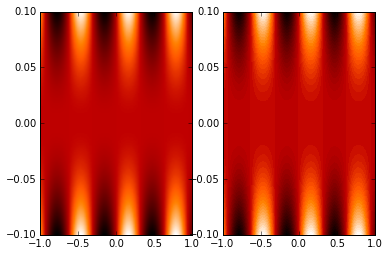

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
import time
import numpy as np
from mmfutils import plot as mmfplt
x = np.linspace(-1, 1, 100)[:, None]
y = np.linspace(-0.1, 0.1, 200)[None, :]
z = np.sin(10*x)*y**2
plt.subplot(121)
%time mmfplt.imcontourf(x, y, z)
plt.subplot(122)
%time plt.contourf(x.ravel(), y.ravel(), z.T, 50, cmap='gist_heat')

### 2.5.2 Angular Variables

A couple of tools are provided to visualize angular fields, such as the phase of a complex wavefunction.

/data/apps/anaconda/envs/work/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


(<matplotlib.contour.QuadContourSet instance at 0x115bc5248>,
 <matplotlib.contour.QuadContourSet instance at 0x115be2dd0>)

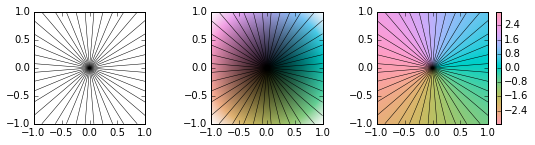

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
import time
import numpy as np
from mmfutils import plot as mmfplt;reload(mmfplt)
x = np.linspace(-1, 1, 100)[:, None]
y = np.linspace(-1, 1, 200)[None, :]
z = x + 1j*y

plt.figure(figsize=(9,2))
plt.subplot(131).set_aspect(1)
mmfplt.phase_contour(x, y, z, aspect=1, colors='k', linewidths=0.5)

# This is a little slow but allows you to vary the luminosity.
plt.subplot(132).set_aspect(1)
mmfplt.imcontourf(x, y, mmfplt.color_complex(z), aspect=1)
mmfplt.phase_contour(x, y, z, aspect=1, linewidths=0.5)

# This is faster if you just want to show the phase and allows
# for a colorbar via a registered colormap
plt.subplot(133).set_aspect(1)
mmfplt.imcontourf(x, y, np.angle(z), cmap='huslp', aspect=1)
plt.colorbar()
mmfplt.phase_contour(x, y, z, aspect=1, linewidths=0.5)

## 2.6 Debugging

A couple of debugging tools are provided.  The most useful is the `debug` decorator which will store the local variables of a function in a dictionary or in your global scope.

In [20]:
from mmfutils.debugging import debug

@debug(locals())
def f(x):
    y = x**1.5
    z = 2/x
    return z

print(f(2.0), x, y, z)

(1.0, 2.0, 2.8284271247461903, 1.0)


## 2.7 Mathematics

We include a few mathematical tools here too.  In particular, numerical integration and differentiation.  Check the API documentation for details.

# 3. Developer Instructions

If you are a developer of this package, there are a few things to be aware of.

1. If you modify the notebooks in ``docs/notebooks`` then you may need to regenerate some of the ``.rst`` files and commit them so they appear on bitbucket.  This is done automatically by the ``pre-commit`` hook in ``.hgrc`` if you include this in your ``.hg/hgrc`` file with a line like:

    ```
    %include ../.hgrc
    ```

**Security Warning:** if you do this, be sure to inspect the ``.hgrc`` file carefully to make sure that no one inserts malicious code.

This runs the following code:

In [21]:
!cd $ROOTDIR; ipython nbconvert --to=rst --output=README.rst doc/README.ipynb

/data/apps/anaconda/envs/work/lib/python2.7/site-packages/pygments/plugin.py:39: UserWarning: Module errno was already imported from None, but /data/src/python/pygsl-0.9.5 is being added to sys.path
  import pkg_resources
[NbConvertApp] Converting notebook doc/README.ipynb to rst
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 44609 bytes to README.rst


We also run a comprehensive set of tests, and the pre-commit hook will fail if any of these do not pass, or if we don't have complete code coverage.  This uses [nosetests](https://nose.readthedocs.org/en/latest/) and [flake8](http://flake8.readthedocs.org).  To run individal tests do one of:

```bash
python setup.py nosetests
python setup.py flake8
python setup.py check
python setup.py test   # This runs them all using a custom command defined in setup.py
```

Here is an example:

In [22]:
!cd $ROOTDIR; python setup.py test

/data/apps/anaconda/envs/work/lib/python2.7/site-packages/distribute-0.6.27-py2.7.egg/setuptools/command/install_scripts.py:3: UserWarning: Module errno was already imported from None, but /data/src/python/pygsl-0.9.5 is being added to sys.path
running test
/data/apps/anaconda/envs/work/lib/python2.7/site-packages/distribute-0.6.27-py2.7.egg/setuptools/dist.py:247: UserWarning: Module flake8 was already imported from /data/apps/anaconda/envs/work/lib/python2.7/site-packages/flake8/__init__.pyc, but /Users/mforbes/work/mmfbb/mmfutils/flake8-2.4.1-py2.7.egg is being added to sys.path
/data/apps/anaconda/envs/work/lib/python2.7/site-packages/distribute-0.6.27-py2.7.egg/setuptools/dist.py:247: UserWarning: Module pep8 was already imported from /data/apps/anaconda/envs/work/lib/python2.7/site-packages/pep8.pyc, but /Users/mforbes/work/mmfbb/mmfutils/pep8-1.5.7-py2.7.egg is being added to sys.path
running nosetests
running egg_info
writing requirements to mmfutils.egg-info/requires.txt
writi

Complete code coverage information is provided in ``build/_coverage/index.html``.

In [23]:
from IPython.display import HTML
with open(os.path.join(ROOTDIR, 'build/_coverage/index.html')) as f:
    coverage = f.read()
HTML(coverage)

Module,statements,missing,excluded,coverage
Total,708,0,71,100%
mmfutils,1,0,0,100%
mmfutils.containers,85,0,0,100%
mmfutils.debugging,47,0,3,100%
mmfutils.interface,47,0,14,100%
mmfutils.math,0,0,0,100%
mmfutils.math.differentiate,61,0,0,100%
mmfutils.math.integrate,193,0,16,100%
mmfutils.monkeypatches,14,0,4,100%
mmfutils.parallel,121,0,8,100%


## 3.1 Releases

We try to keep the repository clean with the following properties:

1. The default branch is stable: i.e. if someone runs `hg clone`, this will pull the latest stable release.
2. Each release has its own named branch so that e.g. `hg up 0.4.6` will get the right thing.  Note: this should update to the development branch, *not* the default branch so that any work committed will not pollute the development branch (which would violate the previous point).

To do this, we advocate the following proceedure.

1. **`hg up <version>`**:  Make sure this is the correct development branch, not the default branch.  (Check by `hg up default` which should take you to the default branch.)
2. **Work**: Do your work, committing as required with messages as shown in the repository with the following keys:

   * `DOC`: Documentation changes.
   * `API`: Changes to the exising API.  This could break old code.
   * `EHN`: Enhancement or new functionality. Without an `API` tag, these should not break existing codes.
   * `BLD`: Build system changes (`setup.py`, `requirements.txt` etc.)
   * `TST`: Update tests, code coverage, etc.
   * `BUG`: Address an issue as filed on the issue tracker.
   * `BRN`: Start a new branch (see below).
   * `REL`: Release (see below).
   * `WIP`: Work in progress.  Do not depend on these!  They will be stripped.  This is useful when testing things like the rendering of documentation on bitbucket etc. where you need to push an incomplete set of files.  Please collapse and strip these eventually when you get things working.
   * `CHK`: Checkpoints.  These should not be pushed to bitbucket!
3. **`python setup.py test`**: Make sure the tests pass.  (`hg com` will do this automatically if you have linked the `.hgrc` file as discussed above.
4. **Update Docs**: Update the documentation if needed.  To generate new documentation run:

     cd doc
     sphinx-apidoc -eTE ../mmfutils -o source
     rm source/mmfutis.tests.*
 
  Edit any new files created (titles often need to be added) and check that this looks good with
  
     make html
     open build/html/index.html
     
  Look especially for errors of the type `WARNING: document isn't included in any toctree`.  This indicates that you probably need to add the module to an upper level `.. toctree::`.  Also look for `WARNING: toctree contains reference to document u'...' that doesn't have a title: no link will be generated`.  This indicates you need to add a title to a new file.  For example, when I added the `mmf.math.optimize` module, I needed to update the following:
  
  ```rst
  .. doc/source/mmfutils.rst
  mmfutils
  ========
  
  .. toctree::
      ...
      mmfutils.optimize
      ...
  ```
  ```rst
  .. doc/source/mmfutils.optimize.rst
  mmfutils.optimize
  =================
      
  .. automodule:: mmfutils.optimize
      :members:
      :undoc-members:
      :show-inheritance:
  ```
  
5. **`hg histedit`**: (or `hg rebase`, or `hg strip` as needed) Clean up the repo before you push.  Branches should generally be linear unless there is an exceptional reason to split development.
6. **Release**: First edit `mmfutils/__init__.py` and update the version number by removing the `dev` part of the version number.  Commit only this change and then push only the branch you are working on:

       hg com -m "REL: <version>"
       hg push -b .
7. Create a pull request on the development fork from your branch to `default` on bitbucket. Review it, fix anything, then accept the PR and close the branch. 
8. **Start new branch**: On the same development branch (not `default`), increase the version number in `mmfutils/__init__.py` and add `dev`: i.e.:

       __version__ = '0.4.7dev'
       
  Then create this branch and commit this:
  
       hg branch "0.4.7"
       hg com -m "BRN: Started branch 0.4.7"